In [1]:
import os
import glob
from collections import OrderedDict

import numpy as np

from scipy import io as sio
from sklearn.decomposition import PCA
import matplotlib.pylab as plt
%matplotlib inline

from keras.utils import np_utils

# TCN imports
import tf_models, ap_datasets, utils, metrics
from utils import imshow_

# ---------- Directories & User inputs --------------
# Location of data/features folder
base_dir = os.path.expanduser("../")

# Set dataset and action label granularity (if applicable)
dataset = ["50Salads", "JIGSAWS", "MERL", "GTEA", "UCF101"][4]
# Set model and parameters
# causal or acausal? (If acausal use Bidirectional LSTM)
causal = [False, True][0]

# How many latent states/nodes per layer of network
# Only applicable to the TCNs. The ECCV and LSTM  model suses the first element from this list.
n_nodes = [64, 96]
conv = {'50Salads':25, "JIGSAWS":20, "MERL":5, "GTEA":25, 'UCF101': 25}[dataset]

# Which features for the given dataset
features = "SpatialCNN"

if dataset == "UCF101":
    base_dir = "/home/jinchoi/src/rehab/dataset/action/UCF101/"
    feature_type = 'pool5_feat'#'relu7_feat'
    model_type = ["AP-TCN", "AP-TCN-SanityCheck"][0]
    num_sample_frames = [16,32,64][0]
    num_sample_clips = [3, 5, 10, 20][2]
    frame_interval = [1,2,3,5,10,20,30][1]
#     max_len = [90,225][0]
    nb_epoch = 40
    

Using TensorFlow backend.


In [2]:
for model_type in ["AP-TCN"]:#, "AP-TCN-SanityCheck"]:
    for num_sample_frames in [16]:
        for num_sample_clips in [10]:
            print('=================================================================================')
            print('=================================================================================')
            print('Training... model_type={0}, num_sample_clips={1}, num_sample_frames={2}, frame_interval={3}'.format(model_type, num_sample_clips, num_sample_frames, frame_interval))
            # Initialize dataset loader & metrics
            if dataset == 'UCF101':
                data = ap_datasets.Dataset(dataset, base_dir, feature_type='fc7')
            else:
                data = ap_datasets.Dataset(dataset, base_dir)

            n_classes = data.n_classes
            test_accuracies = list()
            test_losses = list()
            split_cnt = 0

            # Load data for each split
#             for split in data.splits:
            split = 'Split_01'
            if dataset != 'UCF101':
                feature_type = "A" if model_type != "SVM" else "X"

            # Load the feature files
            print("Loading data split...")
            # If there exist .npy files, load them
            if ( os.path.exists(base_dir + 'AlexNet-fc7-npy/X_train_ucf_' + split + '_N' + str(num_sample_clips) + '_l' + str(num_sample_frames) + '_d' + str(frame_interval) + '.npy') and
                 os.path.exists(base_dir + 'AlexNet-fc7-npy/y_train_ucf_' + split + '_N' + str(num_sample_clips) + '_l' + str(num_sample_frames) + '_d' + str(frame_interval) + '.npy') and
                 os.path.exists(base_dir + 'AlexNet-fc7-npy/X_test_ucf_' + split + '_N' + str(num_sample_clips) + '_l' + str(num_sample_frames) + '_d' + str(frame_interval) + '.npy') and
                 os.path.exists(base_dir + 'AlexNet-fc7-npy/y_test_ucf_' + split + '_N' + str(num_sample_clips) + '_l' + str(num_sample_frames) + '_d' + str(frame_interval) + '.npy') ):
                print("npy files found.")
                X_train = np.load(base_dir + 'AlexNet-fc7-npy/X_train_ucf_' + split + '_N' + str(num_sample_clips) + '_l' + str(num_sample_frames) + '_d' + str(frame_interval) + '.npy');
                y_train = np.load(base_dir + 'AlexNet-fc7-npy/y_train_ucf_' + split + '_N' + str(num_sample_clips) + '_l' + str(num_sample_frames) + '_d' + str(frame_interval) + '.npy');
                X_test = np.load(base_dir + 'AlexNet-fc7-npy/X_test_ucf_' + split + '_N' + str(num_sample_clips) + '_l' + str(num_sample_frames) + '_d' + str(frame_interval) + '.npy');
                y_test = np.load(base_dir + 'AlexNet-fc7-npy/y_test_ucf_' + split + '_N' + str(num_sample_clips) + '_l' + str(num_sample_frames) + '_d' + str(frame_interval) + '.npy');
            # If there are no .npy files, load .mat files and generate the numpy features
            else:
                print("npy files not found. Loading from mat files. This would take a while...")
                X_train, y_train, X_test, y_test = data.load_split_ucf(split=split, num_sample_clips=num_sample_clips, 
                                                                       num_sample_frames=num_sample_frames, sample_rate=frame_interval,
                                                                       feature_type=feature_type)
                np.save(base_dir + 'AlexNet-fc7-npy/X_train_ucf_' + split + '_N' + str(num_sample_clips) + '_l' + str(num_sample_frames) + '_d' + str(frame_interval) + '.npy', X_train);
                np.save(base_dir + 'AlexNet-fc7-npy/y_train_ucf_' + split + '_N' + str(num_sample_clips) + '_l' + str(num_sample_frames) + '_d' + str(frame_interval) + '.npy', y_train);
                np.save(base_dir + 'AlexNet-fc7-npy/X_test_ucf_' + split + '_N' + str(num_sample_clips) + '_l' + str(num_sample_frames) + '_d' + str(frame_interval) + '.npy', X_test);
                np.save(base_dir + 'AlexNet-fc7-npy/y_test_ucf_' + split + '_N' + str(num_sample_clips) + '_l' + str(num_sample_frames) + '_d' + str(frame_interval) + '.npy', y_test);
            print("Loading done.")

            n_feat = data.n_features = X_train[0].shape[1]

            # --------- ICCV model ----------
            # for train a softmax classfier, we need one-hot encoded labels, from 0 to 100
            Y_train = [np_utils.to_categorical(y-1, n_classes) for y in y_train]
            Y_train_ = np.array(Y_train)
            y_train_ = [np.array([y_train[i]]) for i in range(len(y_train))] # no need

            # for train a softmax classfier, we need one-hot encoded labels, from 0 to 100
            Y_test = [np_utils.to_categorical(y-1, n_classes) for y in y_test]
            Y_test_ = np.array(Y_test)
            y_test_ = [np.array([y_test[i]]) for i in range(len(y_test))] # no need

            # In order process batches simultaneously all data needs to be of the same length
            # So make all same length and mask out the ends of each.
            n_layers = len(n_nodes)

#             X_train_m = X_train
#             X_test_m = X_test

#             ###  Random shuffle of the training data and corresponding labels
#             ###  This is important since the Keras model.fit function does shuffle
#             ###  after sampling the last portion of the training data !!!
#             print("Shuffling the training data...")
#             rand_ind = np.random.permutation(len(X_train_m)/)
#             X_train_m_shuffle = X_train_m[rand_ind,:,:]
#             Y_train_shuffle   = np.array( [Y_train[rand_ind[i]] for i in range(len(Y_train))] )
#             print("Shuffling done")

            if model_type == "AP-TCN":
                print('Training AP-TCN...')
                model, param_str = tf_models.AP_TCN(n_nodes, conv, n_classes, n_feat, num_sample_frames, causal=causal, activation='norm_relu', return_param_str=True)
            elif model_type == "AP-TCN-SanityCheck":
                model, param_str = tf_models.AP_TCN_SanityCheck(n_nodes, conv, n_classes, n_feat, num_sample_frames, causal=causal,
                                                    activation='norm_relu', return_param_str=True)

            model.summary()
            
            M_train2 = np.array([[1] for i in range(len(X_train))])

            # fitting a model
            print('model_type={0}, num_sample_clips={1}, num_sample_frames={2}, frame_interval={3}, nb_epoch={4}, split={5}'.format(model_type, num_sample_clips, num_sample_frames, frame_interval, nb_epoch, split))
            model.fit(X_train, Y_train_, nb_epoch=nb_epoch, batch_size=8, verbose=1, shuffle=True, sample_weight=M_train2)

            print(param_str)

            print('Evaluation on blind test dataset')
            [test_loss, test_accuracy] = model.evaluate(X_test_m, Y_test_)
            test_accuracies.append(test_accuracy)
            test_losses.append(test_accuracy)
            print('Test Accuracy: {0}, Test Loss:{1}'.format(test_accuracy, test_loss))

            # save the model
            model.save('../models/{0}_N{1}_l{2}_d{3}_{4}_{5}_epoch{6}.h5'.format(model_type, num_sample_clips, num_sample_frames, frame_interval, dataset, split, nb_epoch))

            split_cnt += 1
            if split_cnt >= 1:
                break;

        print 'Mean test accuracy: {0}'.format(np.mean(test_accuracies))
        print('=================================================================================')
        print('=================================================================================')

Training... model_type=AP-TCN, num_sample_clips=10, num_sample_frames=16, frame_interval=2
Loading data split...
npy files not found. Loading from mat files. This would take a while...
Loading the test data: 100% Shuffling the training data...
Shuffling done.
Random window subsampling...
Random window subsampling done.
Loading done.
Training AP-TCN...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 16, 4096)      0                                            
____________________________________________________________________________________________________
convolution1d_1 (Convolution1D)  (None, 16, 64)        6553664     input_1[0][0]                    
____________________________________________________________________________________________________
spatialdropout1d_1 (SpatialDropo (None, 

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 arrays but instead got the following list of 95370 arrays: [array([[ 0.        ,  0.        ,  1.07650769, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.04213333, ...,  0.        ,
         0.        ,  0.        ],...

In [3]:
len(X_train)

95370

In [4]:
len(y_train)

95370

In [9]:
nb_video_samples

25

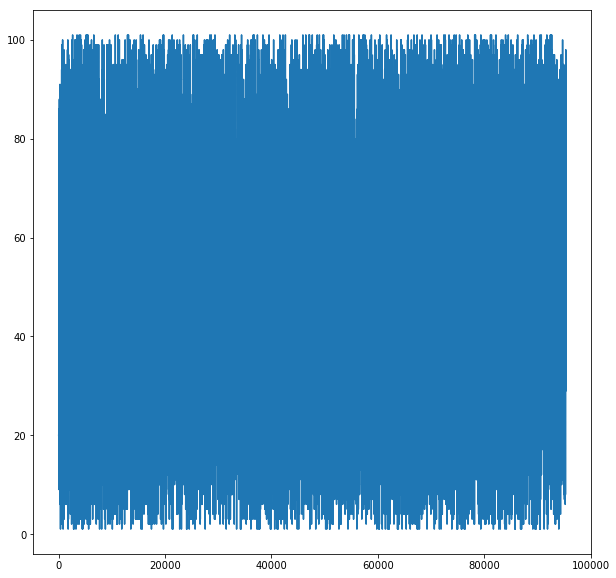

In [6]:
plt.plot(y_train)

In [11]:
X_train[0].shape

(16, 4096)

In [13]:
start=46
for i in np.arange(start,start+32,2):
    print(X_train[1][i,:])

[ 0.          0.          0.73018193 ...,  0.31052467  0.          0.        ]
[ 0.          0.          0.73489696 ...,  0.27571946  0.          0.        ]
[ 0.          0.          0.80709356 ...,  0.33054104  0.          0.        ]
[ 0.          0.          0.76772559 ...,  0.32916766  0.          0.        ]
[ 0.          0.          0.7402488  ...,  0.32064837  0.          0.        ]
[ 0.          0.          0.72423065 ...,  0.30629796  0.          0.        ]
[ 0.          0.          0.7165966  ...,  0.28583425  0.          0.        ]
[ 0.          0.          0.80922979 ...,  0.30653897  0.          0.        ]
[ 0.          0.          0.77644408 ...,  0.30669218  0.          0.        ]
[ 0.          0.          0.74664843 ...,  0.31082964  0.          0.        ]
[ 0.          0.          0.72099745 ...,  0.30462128  0.          0.        ]
[ 0.          0.          0.70918596 ...,  0.28124946  0.          0.        ]
[ 0.          0.          0.81134689 ...,  0.2812718

In [26]:
np.random.seed(0)
rand_ind = np.random.permutation(9537)

In [27]:
rand_ind

array([1842, 1824, 8095, ..., 4859, 3264, 2732])

In [28]:
np.random.seed(0)
rand_ind2 = np.random.permutation(3000)

In [8]:
X_train[0].shape[1]

4096

In [47]:
                n_feat = data.n_features = X_train[0].shape[1]

                # --------- ICCV model ----------
                # for train a softmax classfier, we need one-hot encoded labels, from 0 to 100
                Y_train = [np_utils.to_categorical(y-1, n_classes) for y in y_train]
                Y_train_ = np.array(Y_train)
                y_train_ = [np.array([y_train[i]]) for i in range(len(y_train))] # no need

                # for train a softmax classfier, we need one-hot encoded labels, from 0 to 100
                Y_test = [np_utils.to_categorical(y-1, n_classes) for y in y_test]
                Y_test_ = np.array(Y_test)
                y_test_ = [np.array([y_test[i]]) for i in range(len(y_test))] # no need

                # In order process batches simultaneously all data needs to be of the same length
                # So make all same length and mask out the ends of each.
                n_layers = len(n_nodes)

#                 # don't need masking now
#                 print("Start data masking...")
#                 X_train_m, _ = utils.mask_data_one_tensor(X_train, max_len, mask_value=-1)
#                 X_test_m,  _ = utils.mask_data_one_tensor(X_test,  max_len, mask_value=-1)
#                 print("Data masking done.")
                X_train_m = X_train
                X_test_m = X_test

                ###  Random shuffle of the training data and corresponding labels
                ###  This is important since the Keras model.fit function does shuffle
                ###  after sampling the last portion of the training data !!!
                print("Shuffling the training data...")
                rand_ind = np.random.permutation(len(X_train_m)/)
                X_train_m_shuffle = X_train_m[rand_ind,:,:]
                Y_train_shuffle   = np.array( [Y_train[rand_ind[i]] for i in range(len(Y_train))] )
                print("Shuffling done")

                if model_type == "AP-TCN":
                    print('Training AP-TCN...')
                    model, param_str = tf_models.AP_TCN(n_nodes, conv, n_classes, n_feat, max_len, causal=causal, activation='norm_relu', return_param_str=True)
                elif model_type == "AP-TCN-SanityCheck":
                    model, param_str = tf_models.AP_TCN_SanityCheck(n_nodes, conv, n_classes, n_feat, max_len, causal=causal,
                                                        activation='norm_relu', return_param_str=True)

                model.summary()

Training AP-TCN...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 90, 4096)      0                                            
____________________________________________________________________________________________________
convolution1d_1 (Convolution1D)  (None, 90, 64)        6553664     input_1[0][0]                    
____________________________________________________________________________________________________
spatialdropout1d_1 (SpatialDropo (None, 90, 64)        0           convolution1d_1[0][0]            
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 90, 64)        0           spatialdropout1d_1[0][0]         
________________________________________________________________________

In [ ]:
                M_train2 = np.array([[1] for i in range(len(X_train))])

                # fitting a model
                print('model_type={0}, nb_video_samples={1}, max_len={2}, nb_epoch={3}, split={4}'.format(model_type,nb_video_samples,max_len,nb_epoch,split))
                model.fit(X_train_m_shuffle, Y_train_shuffle, nb_epoch=nb_epoch, batch_size=8, verbose=1, shuffle=True, sample_weight=M_train2)

                print(param_str)

                print('Evaluation on blind test dataset')
                [test_loss, test_accuracy] = model.evaluate(X_test_m, Y_test_)
                test_accuracies.append(test_accuracy)
                test_losses.append(test_accuracy)
                print('Test Accuracy: {0}, Test Loss:{1}'.format(test_accuracy, test_loss))

                # save the model
                model.save('../models/{0}_r{1}_l{2}_{3}_{4}_epoch{5}.h5'.format(model_type, nb_video_samples, max_len, dataset, split, nb_epoch))

                split_cnt += 1
                if split_cnt >= 1:
                    break;

            print 'Mean test accuracy: {0}'.format(np.mean(test_accuracies))
            print('=================================================================================')
            print('=================================================================================')

In [50]:
X_train_sub = utils.random_sample_vectors(X_train, rate=2, dim=0)

[10 58 68 82 53 66 51 55 11  3]
[50 72 18  8 47 42 82 84 92 67]


In [51]:
start=108
for i in np.arange(start,start+32,2):
    print(X_train[1][i,:])

[ 0.          0.          0.76054406 ...,  0.23058879  0.          0.        ]
[ 0.          0.          0.82376575 ...,  0.34040159  0.          0.        ]
[ 0.          0.          0.78102684 ...,  0.30395961  0.          0.        ]
[ 0.          0.          0.76381171 ...,  0.27275494  0.          0.        ]
[ 0.          0.          0.77648127 ...,  0.25974259  0.          0.        ]
[ 0.          0.          0.77580583 ...,  0.24450886  0.          0.        ]
[ 0.          0.          0.81875956 ...,  0.33516544  0.          0.        ]
[ 0.          0.          0.77524388 ...,  0.31666487  0.          0.        ]
[ 0.          0.          0.76026493 ...,  0.28721404  0.          0.        ]
[ 0.          0.          0.77383292 ...,  0.26948518  0.          0.        ]
[ 0.          0.          0.77401066 ...,  0.24847662  0.          0.        ]
[ 0.          0.          0.81576526 ...,  0.33111554  0.          0.        ]
[ 0.          0.          0.7694838  ...,  0.3154130

In [52]:
X_train_sub[1]

[array([[ 0.        ,  0.        ,  0.80709356, ...,  0.33054104,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.76772559, ...,  0.32916766,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.7402488 , ...,  0.32064837,
          0.        ,  0.        ],
        ..., 
        [ 0.        ,  0.        ,  0.72362971, ...,  0.29357228,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.70849943, ...,  0.28040704,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.8141948 , ...,  0.24692726,
          0.        ,  0.        ]], dtype=float32),
 array([[ 0.        ,  0.        ,  0.78489095, ...,  0.28462642,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.75353634, ...,  0.2924692 ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.72362971, ...,  0.29357228,
          0.        ,  0.        ],
        ..., 
        [ 0.        ,  0.        ,  0

In [53]:
len(X_train_sub)

9537

In [54]:
X_train_sub

[[array([[ 0.        ,  0.        ,  0.81958973, ...,  0.35059461,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.77961969, ...,  0.32521042,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.77224088, ...,  0.29648274,
           0.        ,  0.        ],
         ..., 
         [ 0.        ,  0.        ,  0.7642653 , ...,  0.29421383,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.77538729, ...,  0.26544142,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.81992722, ...,  0.3369894 ,
           0.        ,  0.        ]], dtype=float32),
  array([[ 0.        ,  0.        ,  0.73649096, ...,  0.28687462,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.82378209, ...,  0.30788144,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.79297686, ...,  0.3076441 ,
           0.        ,  0.        ],
         ..., 
         [ 0.    

In [55]:
X_train

[array([[ 0.        ,  0.        ,  0.81575966, ...,  0.35495877,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.79301715, ...,  0.34287027,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.77641141, ...,  0.32301131,
          0.        ,  0.        ],
        ..., 
        [ 0.        ,  0.        ,  0.77870631, ...,  0.30938774,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.76576209, ...,  0.30215433,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.75702196, ...,  0.29527375,
          0.        ,  0.        ]], dtype=float32),
 array([[ 0.        ,  0.        ,  0.81425345, ...,  0.36728701,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.7887944 , ...,  0.35802972,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.7706629 , ...,  0.33701825,
          0.        ,  0.        ],
        ..., 
        [ 0.        ,  0.        ,  0

In [56]:
len(X_train)

9537

In [57]:
len(X_train_sub)

9537

In [59]:
len(X_train_sub[0])

10

In [60]:
len(X_train_sub[1])

10

In [87]:
a=[1,2,3]

In [88]:
b=[4,5,6]

In [82]:
a

[1, 2, 3, [4, 5, 6], [4, 5, 6]]

In [91]:
sum([a,b],[])

[1, 2, 3, 4, 5, 6]

In [104]:
sum([X_train_sub[0],X_train_sub[1]],[])

[array([[ 0.        ,  0.        ,  0.81958973, ...,  0.35059461,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.77961969, ...,  0.32521042,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.77224088, ...,  0.29648274,
          0.        ,  0.        ],
        ..., 
        [ 0.        ,  0.        ,  0.7642653 , ...,  0.29421383,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.77538729, ...,  0.26544142,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.81992722, ...,  0.3369894 ,
          0.        ,  0.        ]], dtype=float32),
 array([[ 0.        ,  0.        ,  0.73649096, ...,  0.28687462,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.82378209, ...,  0.30788144,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.79297686, ...,  0.3076441 ,
          0.        ,  0.        ],
        ..., 
        [ 0.        ,  0.        ,  0

In [105]:
X_train_sub[0]

[array([[ 0.        ,  0.        ,  0.81958973, ...,  0.35059461,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.77961969, ...,  0.32521042,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.77224088, ...,  0.29648274,
          0.        ,  0.        ],
        ..., 
        [ 0.        ,  0.        ,  0.7642653 , ...,  0.29421383,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.77538729, ...,  0.26544142,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.81992722, ...,  0.3369894 ,
          0.        ,  0.        ]], dtype=float32),
 array([[ 0.        ,  0.        ,  0.73649096, ...,  0.28687462,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.82378209, ...,  0.30788144,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.79297686, ...,  0.3076441 ,
          0.        ,  0.        ],
        ..., 
        [ 0.        ,  0.        ,  0

In [106]:
X_train_sub[1]

[array([[ 0.        ,  0.        ,  0.80709356, ...,  0.33054104,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.76772559, ...,  0.32916766,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.7402488 , ...,  0.32064837,
          0.        ,  0.        ],
        ..., 
        [ 0.        ,  0.        ,  0.72362971, ...,  0.29357228,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.70849943, ...,  0.28040704,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.8141948 , ...,  0.24692726,
          0.        ,  0.        ]], dtype=float32),
 array([[ 0.        ,  0.        ,  0.78489095, ...,  0.28462642,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.75353634, ...,  0.2924692 ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.72362971, ...,  0.29357228,
          0.        ,  0.        ],
        ..., 
        [ 0.        ,  0.        ,  0